# ECG Federated 1D-CNN Client Side
This code is the server part of ECG federated 1D-CNN model for **multi** client and a server.

In [22]:
users = 1 # number of clients

In [23]:
import os
import h5py

import socket
import struct
import pickle

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torch.utils.data import Dataset, DataLoader
from torch.optim import Adam

# for image
# import matplotlib.pyplot as plt
# import numpy as np

import time

from tqdm import tqdm

In [24]:
root_path = '../../models/'

## Cuda

In [25]:
# device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device = "cpu"
print(device)

cpu


In [26]:
client_order = int(input("client_order(start from 0): "))

client_order(start from 0):  0


In [27]:
num_traindata = 13244 // users

## Data load

In [28]:
class ECG(Dataset):
    def __init__(self, train=True):
        if train:
            # total: 13244
            with h5py.File(os.path.join(root_path, 'ecg_data', 'train_ecg.hdf5'), 'r') as hdf:
                self.x = hdf['x_train'][num_traindata * client_order : num_traindata * (client_order + 1)]
                self.y = hdf['y_train'][num_traindata * client_order : num_traindata * (client_order + 1)]

        else:
            with h5py.File(os.path.join(root_path, 'ecg_data', 'test_ecg.hdf5'), 'r') as hdf:
                self.x = hdf['x_test'][:]
                self.y = hdf['y_test'][:]
    
    def __len__(self):
        return len(self.x)
    
    def __getitem__(self, idx):
        return torch.tensor(self.x[idx], dtype=torch.float), torch.tensor(self.y[idx])

## Making Batch Generator

In [29]:
batch_size = 32

### `DataLoader` for batch generating
`torch.utils.data.DataLoader(dataset, batch_size=1, shuffle=False)`

In [30]:
train_dataset = ECG(train=True)
test_dataset = ECG(train=False)
trainloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
testloader = DataLoader(test_dataset, batch_size=batch_size)

### Number of total batches

In [31]:
train_total_batch = len(trainloader)
print(train_total_batch)
test_batch = len(testloader)
print(test_batch)

414
414


## Pytorch layer modules for *Conv1D* Network



### `Conv1d` layer
- `torch.nn.Conv1d(in_channels, out_channels, kernel_size)`

### `MaxPool1d` layer
- `torch.nn.MaxPool1d(kernel_size, stride=None)`
- Parameter `stride` follows `kernel_size`.

### `ReLU` layer
- `torch.nn.ReLU()`

### `Linear` layer
- `torch.nn.Linear(in_features, out_features, bias=True)`

### `Softmax` layer
- `torch.nn.Softmax(dim=None)`
- Parameter `dim` is usually set to `1`.

## Construct 1D-CNN ECG classification model

In [32]:
class EcgConv1d(nn.Module):
    def __init__(self):
        super(EcgConv1d, self).__init__()        
        self.conv1 = nn.Conv1d(1, 16, 7)  # 124 x 16        
        self.relu1 = nn.LeakyReLU()
        self.pool1 = nn.MaxPool1d(2)  # 62 x 16
        self.conv2 = nn.Conv1d(16, 16, 5)  # 58 x 16
        self.relu2 = nn.LeakyReLU()        
        self.conv3 = nn.Conv1d(16, 16, 5)  # 54 x 16
        self.relu3 = nn.LeakyReLU()        
        self.conv4 = nn.Conv1d(16, 16, 5)  # 50 x 16
        self.relu4 = nn.LeakyReLU()
        self.pool4 = nn.MaxPool1d(2)  # 25 x 16
        self.linear5 = nn.Linear(25 * 16, 128)
        self.relu5 = nn.LeakyReLU()        
        self.linear6 = nn.Linear(128, 5)
        self.softmax6 = nn.Softmax(dim=1)
    
    def forward(self, x):
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.pool1(x)        
        x = self.conv2(x)
        x = self.relu2(x)        
        x = self.conv3(x)
        x = self.relu3(x)        
        x = self.conv4(x)
        x = self.relu4(x)
        x = self.pool4(x)
        x = x.view(-1, 25 * 16)
        x = self.linear5(x)
        x = self.relu5(x)        
        x = self.linear6(x)
        x = self.softmax6(x)
        return x        

In [33]:
ecg_net = EcgConv1d()
ecg_net.to(device)

EcgConv1d(
  (conv1): Conv1d(1, 16, kernel_size=(7,), stride=(1,))
  (relu1): LeakyReLU(negative_slope=0.01)
  (pool1): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv1d(16, 16, kernel_size=(5,), stride=(1,))
  (relu2): LeakyReLU(negative_slope=0.01)
  (conv3): Conv1d(16, 16, kernel_size=(5,), stride=(1,))
  (relu3): LeakyReLU(negative_slope=0.01)
  (conv4): Conv1d(16, 16, kernel_size=(5,), stride=(1,))
  (relu4): LeakyReLU(negative_slope=0.01)
  (pool4): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (linear5): Linear(in_features=400, out_features=128, bias=True)
  (relu5): LeakyReLU(negative_slope=0.01)
  (linear6): Linear(in_features=128, out_features=5, bias=True)
  (softmax6): Softmax(dim=1)
)

In [34]:
criterion = nn.CrossEntropyLoss()
rounds = 10 # default
local_epochs = 1 # default
lr = 0.001
optimizer = Adam(ecg_net.parameters(), lr=lr)

## Socket initialization
### Required socket functions

In [35]:
def send_msg(sock, msg):
    # prefix each message with a 4-byte length in network byte order
    msg = pickle.dumps(msg)
    msg = struct.pack('>I', len(msg)) + msg
    sock.sendall(msg)

def recv_msg(sock):
    # read message length and unpack it into an integer
    raw_msglen = recvall(sock, 4)
    if not raw_msglen:
        return None
    msglen = struct.unpack('>I', raw_msglen)[0]
    # read the message data
    msg =  recvall(sock, msglen)
    msg = pickle.loads(msg)
    return msg

def recvall(sock, n):
    # helper function to receive n bytes or return None if EOF is hit
    data = b''
    while len(data) < n:
        packet = sock.recv(n - len(data))
        if not packet:
            return None
        data += packet
    return data

### Set host address and port number

In [36]:
host = input("IP address: ")
port = 10080
max_recv = 100000
#172.70.103.230

IP address:  172.70.103.230


### Open the client socket

In [37]:
s = socket.socket()
s.connect((host, port))

## Graph-plotting 

In [38]:
losses = []
accuracies = []
cpu_temps = []
memory_usage = []
cpu_usage = []
times = []

In [39]:
import psutil
import os
# def get_cpu_temperature():
#     try:
#         # Replace the command with the appropriate command for your system
#         command_output = os.popen('sensors').read().strip()

#         print("Command Output:", command_output)  # Print the command output for debugging
        
#         # Check if the expected information is present
#         if 'Core 0' in command_output:
#             temperature_str = command_output.split('Core 0:')[1].strip().split()[0]
#             temperature = float(temperature_str)
#             return temperature
#         else:
#             print("CPU temperature information not found.")
#             return None
#     except Exception as e:
#         print(f"Error getting CPU temperature: {e}")
#         return None

def get_memory_usage():
    # This function gets the available physical memory using psutil
    try:
        mem_info = psutil.virtual_memory()
        return mem_info.available
    except Exception as e:
        print(f"Error getting memory usage: {e}")
        return None

def get_cpu_usage():
    # This function gets the current CPU usage percentage
    try:
        cpu_percent = psutil.cpu_percent(interval=1)
        return cpu_percent
    except Exception as e:
        print(f"Error getting CPU usage: {e}")
        return None

In [40]:
# a = get_cpu_temperature()
b = get_memory_usage()
c = get_cpu_usage()

## SET TIMER

In [41]:
start_time = time.time()    # store start time
print("timmer start!")

timmer start!


In [42]:
msg = recv_msg(s)
rounds = msg['rounds'] 
client_id = msg['client_id']
local_epochs = msg['local_epoch']
send_msg(s, len(train_dataset))

In [43]:
# update weights from server
# train
for r in range(rounds):  # loop over the dataset multiple times
    weights = recv_msg(s)
    ecg_net.load_state_dict(weights)
    ecg_net.eval()
    for local_epoch in range(local_epochs):
        
        for i, data in enumerate(tqdm(trainloader, ncols=100, desc='Round '+str(r+1)+'_'+str(local_epoch+1))):
            
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data
            inputs = inputs.to(device)
            labels = labels.clone().detach().long().to(device)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = ecg_net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            losses.append(loss.item())
            _, predicted = outputs.max(1)
            accuracy = (predicted == labels).sum().item() / labels.size(0)
            accuracies.append(accuracy)

            # cpu_temp = get_cpu_temperature()
            memory = get_memory_usage()
            # cpu_percent = psutil.cpu_percent(interval=1)  # Get CPU usage percentage
            cpu_percent = get_cpu_usage()
            # cpu_temps.append(cpu_temp)
            memory_usage.append(memory)
            cpu_usage.append(cpu_percent)
            
            times.append(time.time() - start_time)

    msg = ecg_net.state_dict()
    send_msg(s, msg)

print('Finished Training')



Round 10_1: 100%|█████████████████████████████████████████████████| 414/414 [07:01<00:00,  1.02s/it]

Finished Training


In [44]:
end_time = time.time()  #store end time
print("Training Time: {} sec".format(end_time - start_time))

Training Time: 4236.225518703461 sec


In [ ]:
# # Plot CPU Temperature vs Time
# plt.figure(figsize=(8, 4))
# plt.plot(times, cpu_temps)
# plt.title('CPU Temperature vs Time')
# plt.xlabel('Time (seconds)')
# plt.ylabel('CPU Temperature')
# plt.show()

In [46]:
import matplotlib.pyplot as plt
import numpy as np

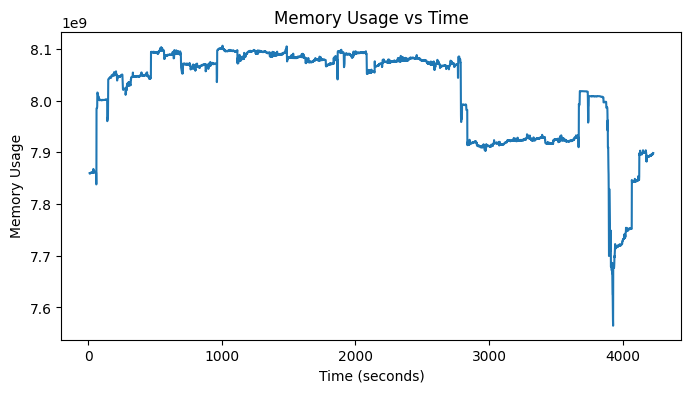

In [47]:
# Plot Memory Usage vs Time
plt.figure(figsize=(8, 4))
plt.plot(times, memory_usage)
plt.title('Memory Usage vs Time')
plt.xlabel('Time (seconds)')
plt.ylabel('Memory Usage')
plt.show()

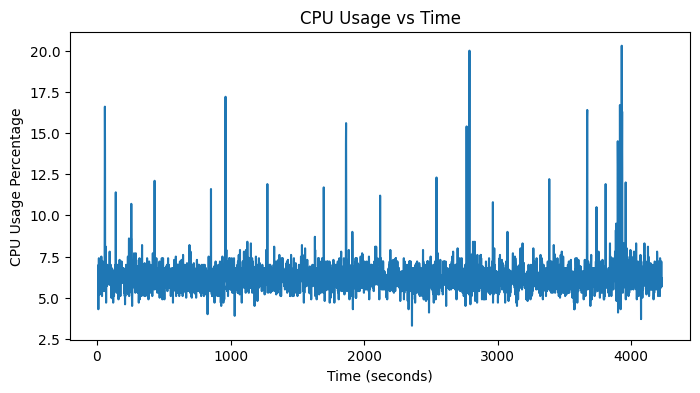

In [48]:
# Plot CPU Usage vs Time
plt.figure(figsize=(8, 4))
plt.plot(times, cpu_usage)
plt.title('CPU Usage vs Time')
plt.xlabel('Time (seconds)')
plt.ylabel('CPU Usage Percentage')
plt.show()

In [24]:
import matplotlib.pyplot as plt
import numpy as np

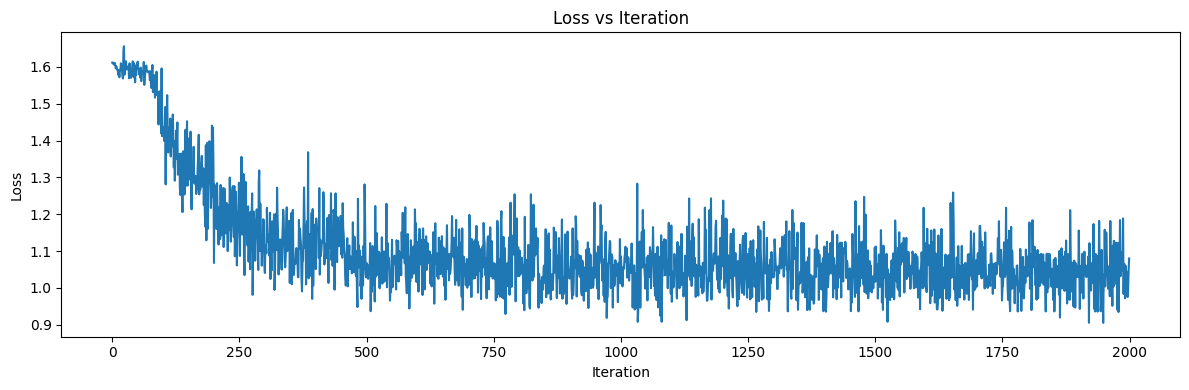

In [33]:
plt.figure(figsize=(12, 4))
# plt.subplot(1, 2, 1)
plt.plot(losses[0:2000])
plt.title('Loss vs Iteration')
plt.xlabel('Iteration')
plt.ylabel('Loss')


# Plot CPU Temperature vs Iteration
# plt.subplot(1, 3, 3)
# plt.plot(cpu_temps)
# plt.title('CPU Temperature vs Iteration')
# plt.xlabel('Iteration')
# plt.ylabel('CPU Temperature')

# Show the plots
plt.tight_layout()
plt.show()

Text(0, 0.5, 'Accuracy')

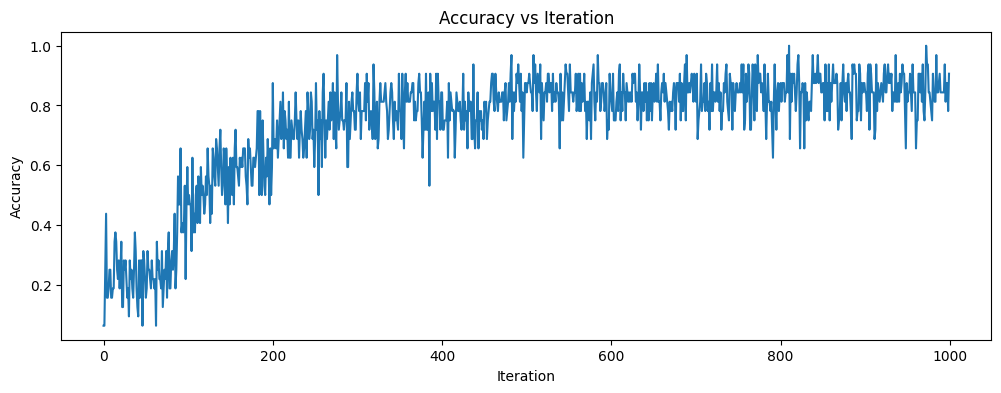

In [32]:
# Plot Accuracy vs Iteration
plt.figure(figsize=(12, 4))
# plt.subplot(1, 2, 2)
plt.plot(accuracies[0:1000])
plt.title('Accuracy vs Iteration')
plt.xlabel('Iteration')
plt.ylabel('Accuracy')

In [ ]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(times, cpu_temps)
plt.title('CPU Temperature vs Time')
plt.xlabel('Time (seconds)')
plt.ylabel('CPU Temperature')

# Plot Memory Usage vs Iteration
plt.subplot(1, 2, 2)
plt.plot(times, memory_usage)
plt.title('Memory Usage vs Time')
plt.xlabel('Time (seconds)')
plt.ylabel('Memory Usage')

# Show the plots
plt.tight_layout()
plt.show()